# **주요 내용**

*   dense layer의 activation function으로 softmax 대신 linear 사용하여 성능 평가


In [1]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8116136482989689126, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2724074822864321252
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5605614313397400803
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5959145716845741256
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
import platform
platform.platform()

'Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic'

In [4]:
!nvidia-smi

Thu Apr 16 12:51:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**파일 압축 해제 (드라이브에는 *.zip 파일 형식으로 저장되어 있음)**

In [6]:
import os

pcm_path = "./pcm_dataset"
wav_path = "./wav_dataset"

# mkdir
if not os.path.exists(pcm_path):
    os.mkdir(pcm_path)

if not os.path.exists(wav_path):
    os.mkdir(wav_path)

# unzip with quite mode (-q options)
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./pcm_dataset"

print(os.listdir(pcm_path)[:5])
print(len(os.listdir(pcm_path)))

['GSM09752SCY0', 'GSF06654KES0', 'GSM03823YJK0', 'GSM07042NSK0', 'I4F02821YRR0']
50


***.pcm to *.wav**

In [7]:
import wave

for i, folder_path in enumerate(sorted(os.listdir(pcm_path))): # sorted!!!
    file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(sorted(file_list_pcm)): # sorted!!!
        with open(os.path.join(pcm_path, folder_path, file_path), "rb") as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(wav_path, "{}_{}.wav".format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

# print samples
print(os.listdir(wav_path)[:5])
print(len(os.listdir(wav_path)))

['35_45.wav', '41_33.wav', '5_61.wav', '37_47.wav', '13_41.wav']
5000


In [0]:
import numpy as np

num_labels = 50
num_features = 100
data_length = 3 ** 9

train_rate = 0.8
num_train_data = int(num_features * train_rate) # 80

select_train_data = [True] * num_train_data + [False] * (num_features - num_train_data)
select_test_data = [False] * num_train_data + [True] * (num_features - num_train_data)

# naming
save_train_data_name = 'train_data'
save_train_labels_name = 'train_labels'

save_test_data_name = 'test_data'
save_test_labels_name = 'test_labels'

notebookName = "20200416"

**train data, test data로 구분하여 numpy 저장 (*.npz)**

In [9]:
# save features as *.npz format

from scipy.io import wavfile

data = np.zeros((num_labels * num_features, data_length))
labels = np.zeros((num_labels * num_features))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(wav_path, file_name))
        
        start = int(len(samples) - data_length) // 2
        end = start + data_length
        
        data[i * num_features + j] = samples[start:end]
        labels[i * num_features + j] = i

train_data = data[select_train_data * num_labels]
train_labels = labels[select_train_data * num_labels]

test_data = data[select_test_data * num_labels]
test_labels = labels[select_test_data * num_labels]

# save *.npy        
np.save("./" + save_train_data_name, train_data)
np.save("./" + save_train_labels_name, train_labels)

np.save("./" + save_test_data_name, test_data)
np.save("./" + save_test_labels_name, test_labels)

print("train_data.shape: {}, train_labels.shape: {}".format(train_data.shape, train_labels.shape))
print("test_data.shape: {}, test_labels.shape: {}".format(test_data.shape, test_labels.shape))

train_data.shape: (4000, 19683), train_labels.shape: (4000,)
test_data.shape: (1000, 19683), test_labels.shape: (1000,)


**train data, validation data 분할 및 전처리 (normalization)**

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

random_state = 1234
test_size = 0.2

X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels,
                                                  test_size = test_size,
                                                  random_state = random_state) # fixed

x_train = X_train.reshape(len(X_train), data_length, 1)
x_val = X_val.reshape(len(X_val), data_length, 1) 

y_train = to_categorical(Y_train)
y_val = to_categorical(Y_val)

# standarization
mean = x_train.mean()
x_train -= mean
std = x_train.std()
x_train /= std

x_val -= mean
x_val /= std 

print("test_size: {}, random_state: {}\n".format(test_size, random_state))
print('x_train.shape: {}, y_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_val.shape: {}, y_val.shape: {}'.format(x_val.shape, y_val.shape))

test_size: 0.2, random_state: 1234

x_train.shape: (3200, 19683, 1), y_train.shape: (3200, 50)
x_val.shape: (800, 19683, 1), y_val.shape: (800, 50)


**Build Model (activation function of dense layer == linear)**

In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

model = Sequential(name = notebookName)

# convolutional layer (4 blocks)
model.add(layers.Conv1D(name = "block1_conv", filters = 16, kernel_size = 3, strides = 1, 
                        padding = "same", activation = 'relu', input_shape = (data_length, 1)))
model.add(layers.MaxPooling1D(name = "block1_pool", pool_size = 3))
model.add(layers.BatchNormalization(name = "block1_norm"))

model.add(layers.Conv1D(name = "block2_conv", filters = 32, kernel_size = 3, strides = 1,
                        padding = "same", activation = 'relu'))
model.add(layers.MaxPooling1D(name = "block2_pool", pool_size = 3))
model.add(layers.BatchNormalization(name = "block2_norm"))

model.add(layers.Conv1D(name = "block3_conv", filters = 64, kernel_size = 3, strides = 1,
                        padding = "same", activation = 'relu'))
model.add(layers.MaxPooling1D(name = "block3_pool", pool_size = 3))
model.add(layers.BatchNormalization(name = "block3_norm"))

model.add(layers.Conv1D(name = "block4_conv", filters = 128, kernel_size = 3, strides = 1,
                        padding = "same", activation = 'relu'))
model.add(layers.MaxPooling1D(name = "block4_pool", pool_size = 3))
model.add(layers.BatchNormalization(name = "block4_norm"))

# mapping from (3**4, 128) to (128) by GlobalAveragePooling1D()
model.add(layers.GlobalAveragePooling1D(name = "global_average_pooling"))
# model.add(layers.Dense(num_labels, activation = 'softmax', name = "dense"))
model.add(layers.Dense(num_labels, activation = 'linear', name = "dense"))

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()
# plot_model(model, show_shapes = True, to_file = 'model.png')

Model: "20200416"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv (Conv1D)         (None, 19683, 16)         64        
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 6561, 16)          0         
_________________________________________________________________
block1_norm (BatchNormalizat (None, 6561, 16)          64        
_________________________________________________________________
block2_conv (Conv1D)         (None, 6561, 32)          1568      
_________________________________________________________________
block2_pool (MaxPooling1D)   (None, 2187, 32)          0         
_________________________________________________________________
block2_norm (BatchNormalizat (None, 2187, 32)          128       
_________________________________________________________________
block3_conv (Conv1D)         (None, 2187, 64)          620

**모델 훈련 및 저장**

In [15]:
batch_size = 80
epochs = 500

print("Train on {} samples, validate on {} samples...".format(x_train.shape[0], x_val.shape[0]))
history = model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 0)

Train on 3200 samples, validate on 800 samples...


**모델 및 결과 저장**

In [16]:
def history_to_numpy(history):
    npy_history = np.array([history.history['accuracy'],
                            history.history['val_accuracy'],
                            history.history['loss'],
                            history.history['val_loss']])
    
    print("saved as 'acc', 'val_acc', 'loss', 'val_loss'")
    return npy_history

save_model_path = "/content/drive/My Drive/models" # save to my drive
if not os.path.exists(save_model_path):
    os.mkdir(save_model_path)

save_results_path = "/content/drive/My Drive/results"
if not os.path.exists(save_results_path):
    os.mkdir(save_results_path)

model.save(os.path.join(save_model_path, "{}.h5".format(notebookName)))
np.save(os.path.join(save_results_path, "{}.npy".format(notebookName)), history_to_numpy(history))

# name
print("save_file_name: {}".format(notebookName))

saved as 'acc', 'val_acc', 'loss', 'val_loss'
save_file_name: 20200416


**히스토리 출력**

In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


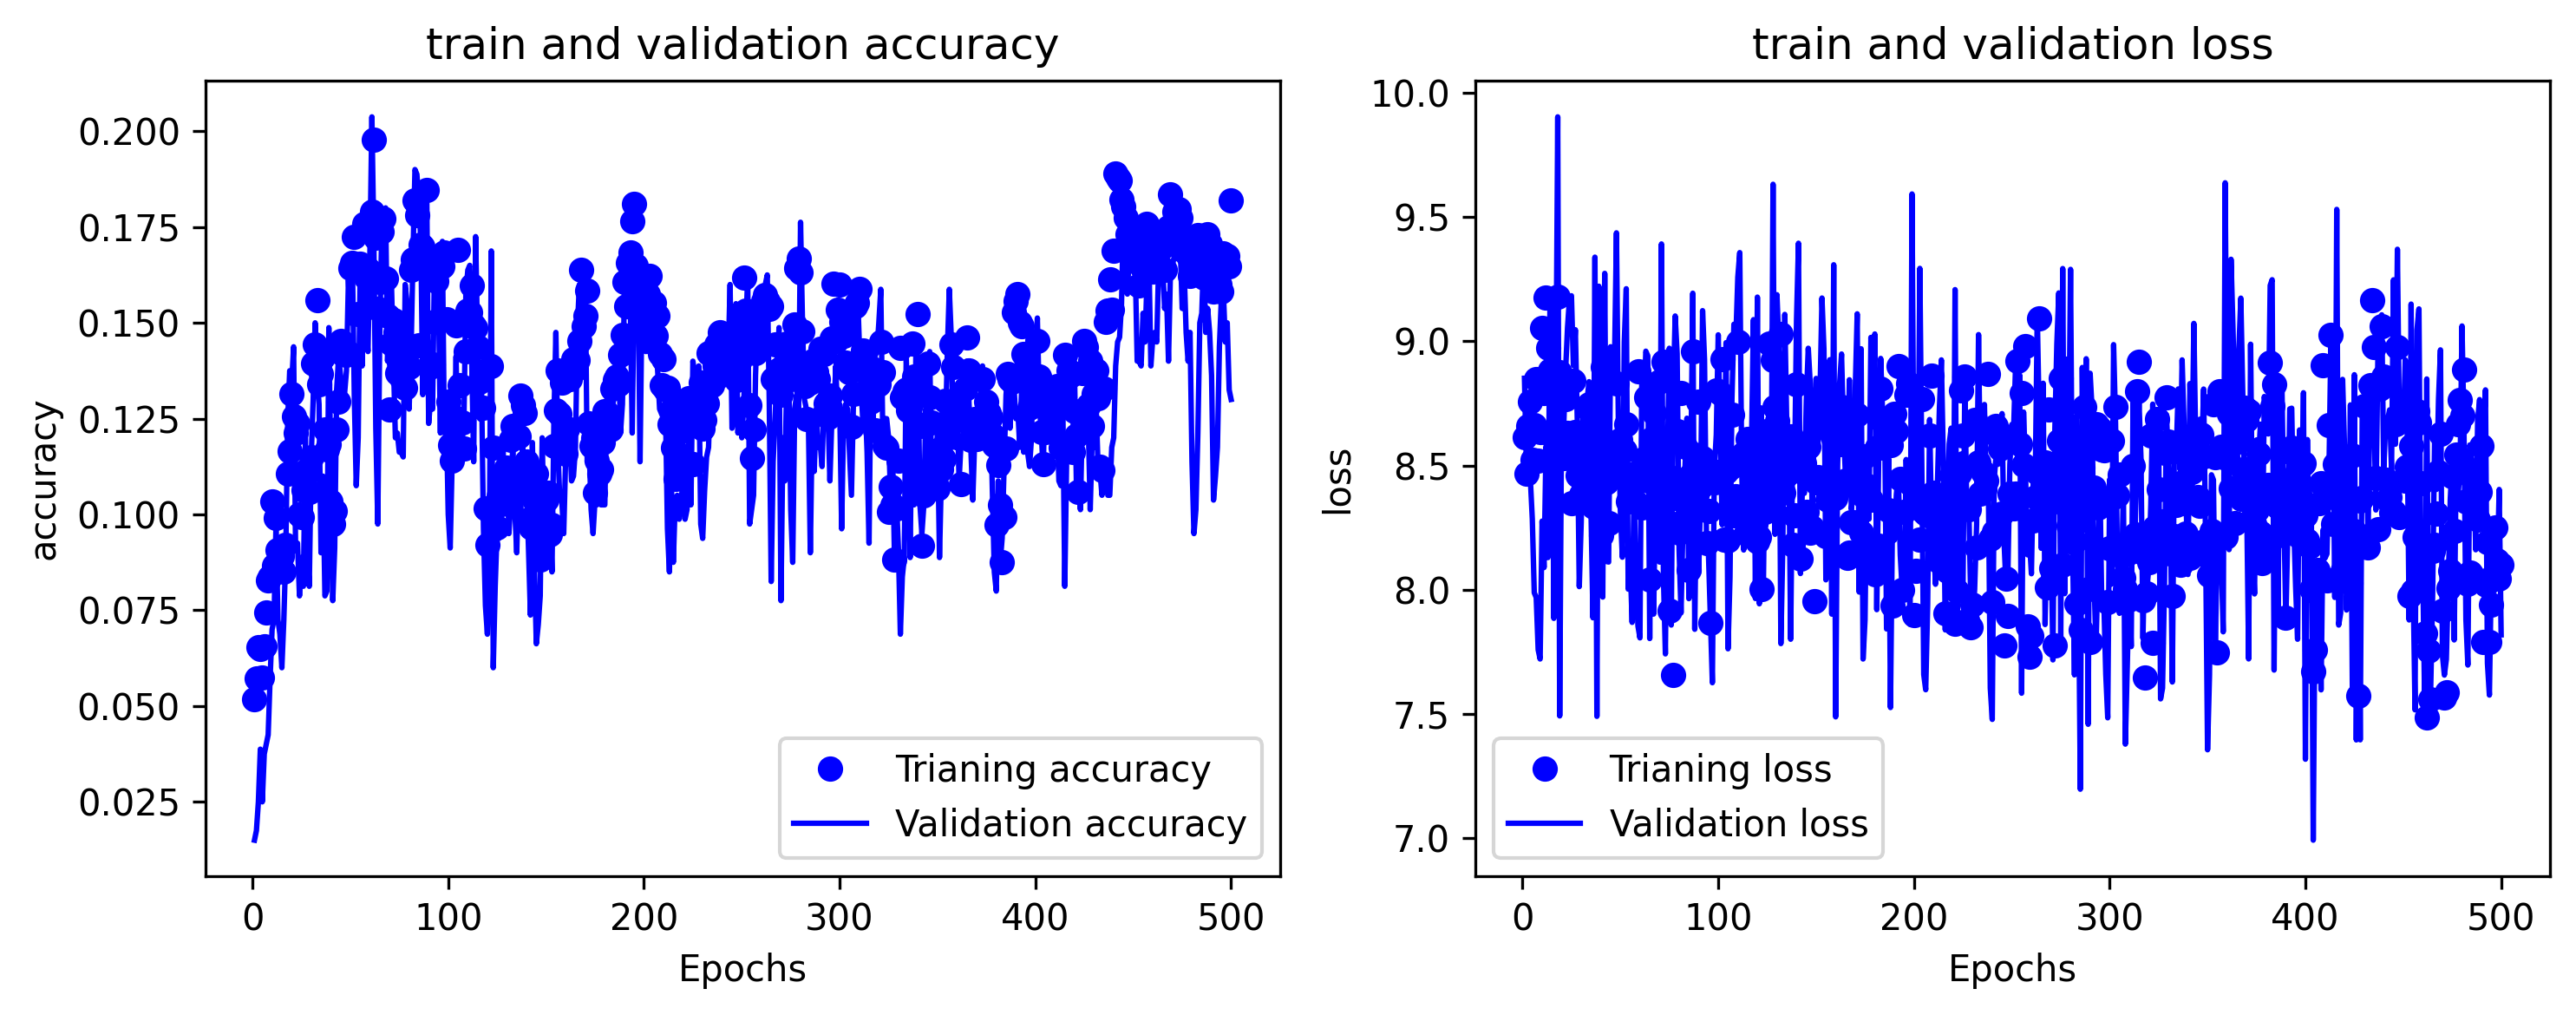

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

# accuracy
plt.subplot(1, 2, 1)

plt.plot(range(1, epochs + 1), acc, 'bo', label = 'Trianing accuracy')
plt.plot(range(1, epochs + 1), val_acc, 'b', label = 'Validation accuracy')
plt.title('train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)

plt.plot(range(1, epochs + 1), loss, 'bo', label = 'Trianing loss')
plt.plot(range(1, epochs + 1), val_loss, 'b', label = 'Validation loss')
plt.title('train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

**test data를 통해 모델 최종 평가 (field test)**

In [19]:
# reshaping
del test_data, test_labels

test_data = np.load(save_test_data_name + ".npy")
test_labels = np.load(save_test_labels_name + ".npy")

test_data = test_data.reshape(len(test_data), data_length, 1)
test_labels = to_categorical(test_labels)

# standarization
test_data -= mean
test_data /= std 

print('test_data.shape: {}, test_labels.shape: {}'.format(test_data.shape, test_labels.shape))

test_data.shape: (1000, 19683, 1), test_labels.shape: (1000, 50)


In [20]:
results = model.evaluate(test_data, test_labels, batch_size = batch_size)

print('test loss, test acc:', results)

13/13 [==============================] - 0s 14ms/step - loss: 7.8421 - accuracy: 0.1500
test loss, test acc: [7.842073917388916, 0.15000000596046448]
